# Download  dataset

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-08-30 08:28:02--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.67.48, 216.58.200.144, 172.217.166.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.67.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  2.91MB/s    in 30s     

2022-08-30 08:28:34 (2.21 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!unzip -qq cats_and_dogs_filtered.zip

# Sneak-Peak on dataset

In [3]:
# !sudo apt-get install tree
!tree -L 2 cats_and_dogs_filtered 

cats_and_dogs_filtered
├── train
│   ├── cats
│   └── dogs
├── validation
│   ├── cats
│   └── dogs
└── vectorize.py

6 directories, 1 file


In [4]:
import os

base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:5])

['cat.791.jpg', 'cat.508.jpg', 'cat.124.jpg', 'cat.117.jpg', 'cat.593.jpg']


In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:


In [7]:
import matplotlib.pyplot as plt
from matplotlib import image
import random

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

number_image_to_take = 4
cat_images = [os.path.join(train_cats_dir, file_name)
                for file_name in random.sample(os.listdir(train_cats_dir), number_image_to_take)]

dog_images = [os.path.join(train_dogs_dir, file_name)
                for file_name in random.sample(os.listdir(train_dogs_dir), number_image_to_take)]

print('cats:', cat_images)
print('dogs:', dog_images)
images = cat_images + dog_images
# print('total image', len(images))

cats: ['cats_and_dogs_filtered/train/cats/cat.81.jpg', 'cats_and_dogs_filtered/train/cats/cat.629.jpg', 'cats_and_dogs_filtered/train/cats/cat.442.jpg', 'cats_and_dogs_filtered/train/cats/cat.847.jpg']
dogs: ['cats_and_dogs_filtered/train/dogs/dog.431.jpg', 'cats_and_dogs_filtered/train/dogs/dog.584.jpg', 'cats_and_dogs_filtered/train/dogs/dog.266.jpg', 'cats_and_dogs_filtered/train/dogs/dog.860.jpg']


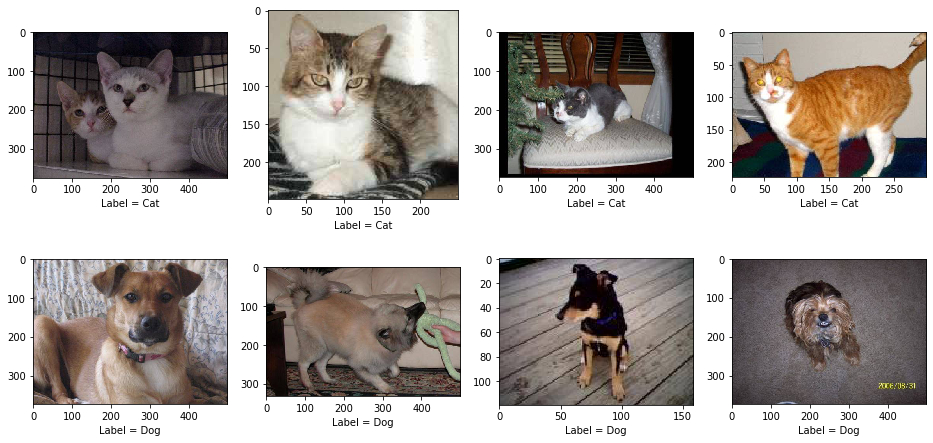

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i, img_path in enumerate(images):
    plt.subplot(nrows, ncols, i+1)
    img = image.imread(img_path)
    plt.imshow(img)
    if i < number_image_to_take:
        plt.xlabel('Label = Cat')
    else:
        plt.xlabel('Label = Dog')

plt.show()

# Creating model

In [9]:
from warnings import filterwarnings
filterwarnings('ignore')

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
# from tenforflow.keras.layers import Dense
# from tenforflow.keras.layers import Conv2D
# from tenforflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [33]:
model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(64,64,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2)) #if stride not given it equal to pool filter size
model.add(Conv2D(32,(3,3),activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dense(units=2,activation='sigmoid'))

# Compile model

In [34]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Preprocessing data using keras 

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,               # This is the source directory for training images
        target_size=(64, 64),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Fit model

In [36]:
history = model.fit_generator(
        train_generator,
        #steps_per_epoch=100,  # 2000 images = batch_size * steps
        steps_per_epoch=len(train_generator),
        epochs=15,
        validation_data=validation_generator,
        #validation_steps=50,  # 1000 images = batch_size * steps
        #validation_steps=10,  # 1000 images = batch_size * steps
        validation_steps=len(validation_generator),
        verbose=2
)

#https://stackoverflow.com/questions/59864408/tensorflowyour-input-ran-out-of-data
#https://stackoverflow.com/questions/62234504/history-model-fit-generator-why-is-keras-history-empty

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 63 steps, validate for 32 steps
Epoch 1/15
63/63 - 7s - loss: 0.6981 - accuracy: 0.5113 - val_loss: 0.6864 - val_accuracy: 0.5005
Epoch 2/15
63/63 - 7s - loss: 0.6807 - accuracy: 0.5545 - val_loss: 0.6508 - val_accuracy: 0.6165
Epoch 3/15
63/63 - 7s - loss: 0.6523 - accuracy: 0.6177 - val_loss: 0.6378 - val_accuracy: 0.6445
Epoch 4/15
63/63 - 7s - loss: 0.6185 - accuracy: 0.6702 - val_loss: 0.5948 - val_accuracy: 0.6695
Epoch 5/15
63/63 - 7s - loss: 0.5853 - accuracy: 0.6917 - val_loss: 0.5985 - val_accuracy: 0.6905
Epoch 6/15
63/63 - 7s - loss: 0.5707 - accuracy: 0.6980 - val_loss: 0.5831 - val_accuracy: 0.6935
Epoch 7/15
63/63 - 7s - loss: 0.5369 - accuracy: 0.7343 - val_loss: 0.5805 - val_accuracy: 0.7015
Epoch 8/15
63/63 - 7s - loss: 0.5209 - accuracy: 0.7372 - val_loss: 0.6449 - val_accuracy: 0.6580
Epoch 9/15
63/63 - 7s - loss: 0.5138 - accuracy: 0.7423 - val_loss: 0.5753 - val_accuracy: 0.7105
Epoch 10/15
63/63 - 7s - l

# Evaluating Model

In [37]:
batch = next(validation_generator)
print('type of batch :', type(batch))
print('batch length  :', len(batch))
print('type batch[0] :', type(batch[0]))
print('type batch[1] :', type(batch[1]))

print('shape batch[0]:', batch[0].shape)
print('shape batch[1]:', batch[1].shape)

# evaluate model
_, acc = model.evaluate_generator(validation_generator, steps=len(validation_generator), verbose=1)
print('Accuracy: %.3f' % (acc * 100.0))

type of batch : <class 'tuple'>
batch length  : 2
type batch[0] : <class 'numpy.ndarray'>
type batch[1] : <class 'numpy.ndarray'>
shape batch[0]: (32, 64, 64, 3)
shape batch[1]: (32, 2)
  ...
    to  
  ['...']
32/32 [==============================] - 2s 52ms/step - loss: 0.5622 - accuracy: 0.7445
Accuracy: 74.450


# Visualizing the training process

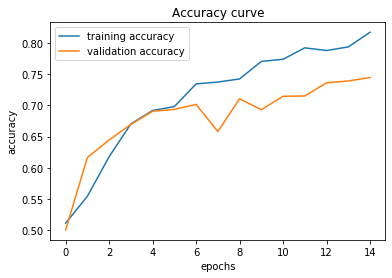

In [38]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

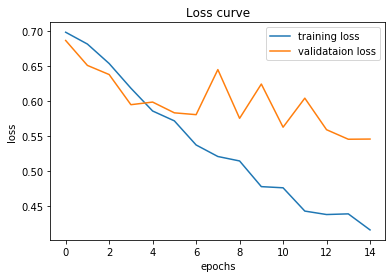

In [39]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validataion loss')
plt.title('Loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# Save and Load model

In [40]:
import os

model_name = 'cat_vs_dog_clf_cnn.h5'
model.save(model_name)
# print('model saved to', os.getcwd())
# !ls -ltr

In [41]:
from tensorflow.keras.models import load_model

loaded_model = load_model(model_name)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

# Test a single image 

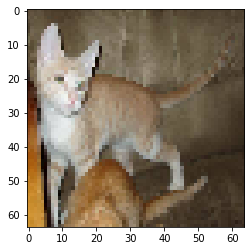

In [42]:
image_index = 5
test_image = batch[0][image_index]
plt.imshow(test_image)
plt.show()

In [43]:
test_image = test_image.reshape(1, 64, 64, 3) # make image batch

pred = loaded_model.predict(test_image)       # prediction

print('pred           :', pred)
print('pred length    :', len(pred[0]))
best_prediction = pred.argmax()
print('best_prediction:', best_prediction)

label = 'Cat' if best_prediction == 0 else 'Dog'
print('Label = {} , Confident = {}'.format(label, pred[0][best_prediction]))

pred           : [[0.5254109  0.45892292]]
pred length    : 2
best_prediction: 0
Label = Cat , Confident = 0.5254108905792236


# Reference

- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
- https://stackoverflow.com/questions/70414028/data-augmentation-with-imagedatagenerator
- https://www.youtube.com/watch?v=Ahy50JCRYNk
- https://www.youtube.com/watch?v=-DDrE6T0ct4